In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [3]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_1.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 9 nodes.
gmshTranslator: Mesh has 9 elements.
gmshTranslator: Processed 22 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [28]:
N_LGL   = 8

xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

xi_tile  = af.transpose(af.tile(xi_LGL, 1, N_LGL))
eta_tile = af.tile(eta_LGL, 1, N_LGL) 

xi_i    = af.flat(af.tile(af.transpose(xi_LGL), N_LGL))
eta_j   = af.tile(eta_LGL, N_LGL)

L_p_coeffs = af.np_to_af_array(lagrange.lagrange_polynomials(xi_LGL)[1])
L_q_coeffs = af.np_to_af_array(lagrange.lagrange_polynomials(eta_LGL)[1])

dLp_dxi_coeffs  = utils.polynomial_derivative(L_p_coeffs)
dLq_deta_coeffs = utils.polynomial_derivative(L_q_coeffs)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [6]:
dxi_dx  = w2d.dxi_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
dxi_dy  = w2d.dxi_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dx = w2d.deta_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dy = w2d.deta_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

In [7]:
def F_xi(u):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    return F_eta_u

In [8]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [9]:
g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

In [10]:
u_ij = np.e ** (- (xi_i**2) / (0.4 ** 2))

u_ij_tile = af.moddims(u_ij, N_LGL, N_LGL)

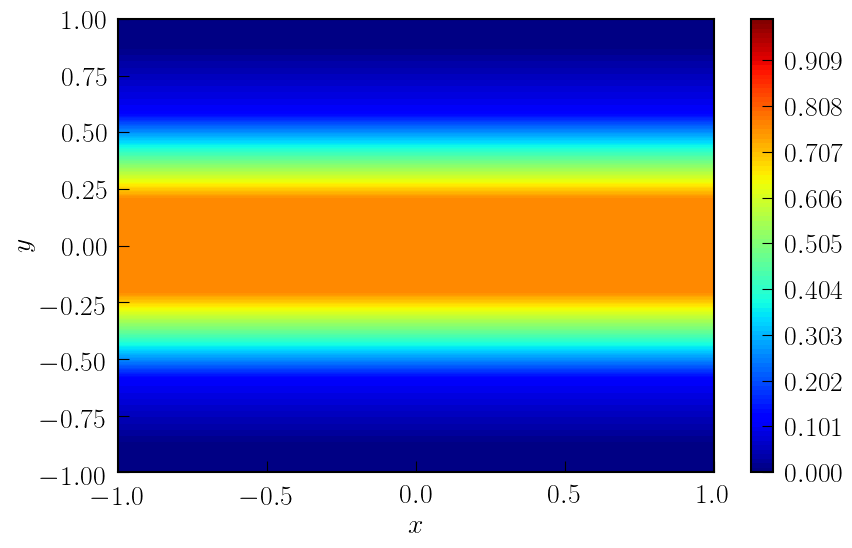

In [11]:
color_levels = np.linspace(0., 1., 100)
plt.contourf(np.array(xi_tile), np.array(eta_tile), np.array(u_ij_tile),200, levels = color_levels, cmap = 'jet')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()
plt.show()

In [12]:
N_LGL = 8
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)
Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

_, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

Li_xi  = af.np_to_af_array(Li_xi)
Lj_eta = af.np_to_af_array(Lj_eta)
Lp_xi  = Li_xi.copy()
Lq_eta = Lj_eta.copy()

# print(Lq_eta)
Lp_xi_tile = af.reorder(Lq_eta, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tile = af.tile(Lp_xi_tile, d0 = N_LGL)
Lp_xi_tile = af.moddims(Lp_xi_tile, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tile = af.reorder(Lp_xi_tile, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tile = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tile = af.tile(Lq_eta_tile, d0 = N_LGL)
Lq_eta_tile = af.reorder(Lq_eta_tile, d0 = 0, d1 = 2, d2 = 1)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [13]:
print(Lp_xi_tile, Lq_eta_tile)

arrayfire.Array()
Type: double

[64 8 1 1]
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
   -3.3516     3.3516     3.8672    -3.8672    -1.0547     1.0547     0.0391    -0.0391 
    8.1407    -7.0966   -11.3475     9.8921     3.3316    -2.9043    -0.1249     0.1088 
    8.1407    -7.0966   -11.3475     9.8921     3.3316    -2.9043    -0.1249     0.1088 
    8.1407    -7.0966   -11.3475     9.8921     3.3316    -2.9043  

In [14]:
for p in range(N_LGL):
    for q in range(N_LGL):
        Lp_value_LGL_points = af.transpose(utils.polyval_1d(L_p_coeffs[p], xi_i))
        Lq_value_LGL_points = af.transpose(utils.polyval_1d(L_q_coeffs[q], eta_j))

        dLp_dxi_LGL_points  = af.transpose(utils.polyval_1d(dLp_dxi_coeffs[p], xi_i))
        dLq_deta_LGL_points = af.transpose(utils.polyval_1d(dLq_deta_coeffs[q], eta_j))
        
        g_00 = g_ab[0][0]
        
        #print(F_xi(u_ij).shape, Lq_value_LGL_points.shape, dLp_dxi_LGL_points.shape)
        v_00            = g_00 * F_xi(u_ij) * Lq_value_LGL_points * dLp_dxi_LGL_points
        volume_integral = af.sum(v_00 * utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss'))
        #print(volume_integral)

In [16]:
utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss')

arrayfire.Array()
Type: double
Dims: (64,)

In [17]:
0.000424369962806095 / 0.0008687503715943605

0.48848320148315644

In [18]:
-0.00250366326102057 / -0.0051253825175652055

0.488483201485989

In [19]:
0.0015928056643658513 / 0.000308073349716018

5.170215683486091